In [103]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.utils import resample
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [104]:
train=pd.read_csv("train.csv")
val=pd.read_csv("validation.csv")
test=pd.read_csv("test.csv")

In [105]:
print("Train size =",len(train))
print("Test size =",len(test))
print("Validation size =",len(val))

Train size = 3900
Test size = 836
Validation size = 836


In [106]:
y_train,X_train=train["label"],train["text"]
y_val,X_val=val["label"],val["text"]
y_test,X_test=val["label"],val["text"]

In [107]:
train['label'].value_counts()

0    3383
1     517
Name: label, dtype: int64

Highly imbalanced data. Hence, we oversample the minority class.

In [108]:
train_majority = train[train["label"]==0]
train_minority = train[train["label"]==1]

In [109]:
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_majority),    # to match majority class
                                 random_state=1234) # reproducible results

In [110]:
train = pd.concat([train_majority, train_minority_upsampled])

In [111]:
y_train,X_train=train["label"],train["text"]
y_val,X_val=val["label"],val["text"]
y_test,X_test=val["label"],val["text"]

In [112]:
train['label'].value_counts()

0    3383
1    3383
Name: label, dtype: int64

In [113]:
# transform the text data to feature vectors that can be used as input to the Logistic regression

feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True',max_features=500)

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

# convert Y_train and Y_test values as integers

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [114]:
print(X_train.shape)
print(X_train_features.shape)

(6766,)
(6766, 500)


# Logistic Regression

In [115]:
model1 = LogisticRegression()

In [116]:
# training the Logistic Regression model with the training data
model1.fit(X_train_features, y_train)

LogisticRegression()

In [117]:
# prediction on training data

prediction_on_training_data = model1.predict(X_train_features)
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)

In [118]:
print('Accuracy on training data : ', accuracy_on_training_data)

Accuracy on training data :  0.9804906887378066


In [119]:
# prediction on test data

y_pred = model1.predict(X_test_features)
accuracy_on_test_data = accuracy_score(y_test, y_pred)

In [120]:
print('Accuracy on test data : ', accuracy_on_test_data)

Accuracy on test data :  0.9808612440191388


In [121]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       725
           1       0.91      0.95      0.93       111

    accuracy                           0.98       836
   macro avg       0.95      0.97      0.96       836
weighted avg       0.98      0.98      0.98       836



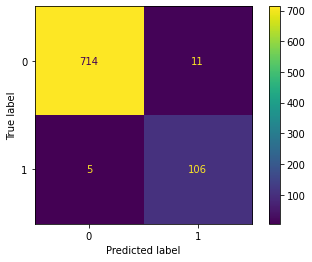

In [122]:
cm = confusion_matrix(y_test, y_pred, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model1.classes_)
disp.plot()
plt.show()

In [123]:
def eval_metrics(actual, pred):
    prec, recall,_ = precision_recall_curve(actual, pred)
    aucpr = auc(recall, prec)
    return aucpr

In [124]:
with mlflow.start_run():
        lr = LogisticRegression()
        lr.fit(X_train_features, y_train)

        predicted_qualities = lr.predict(X_test_features)

        aucpr = eval_metrics(y_test, predicted_qualities)

        print("Logistic Regression model (Area under Precision_Recall Curve={:f}):".format(aucpr))
      
        mlflow.log_param("Area under Precision Recall Curve", aucpr)
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(lr, "model", registered_model_name="LogisticRegressionModel")
        else:
            mlflow.sklearn.log_model(lr, "model")

Logistic Regression model (Area under Precision_Recall Curve=0.933459):


In [125]:
!zip -r /content/mlrunsLR.zip /content/mlruns

updating: content/mlruns/ (stored 0%)
updating: content/mlruns/.trash/ (stored 0%)
updating: content/mlruns/0/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/Area under Precision Recall Curve (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/meta.yaml (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.runName (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.log-model.history (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.user (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.source.type (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/m

In [126]:
from google.colab import files
files.download("/content/mlrunsLR.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# MLP Classifier

In [127]:
model2=MLPClassifier()
model2.fit(X_train_features, y_train)

MLPClassifier()

In [128]:
# prediction on training data

prediction_on_training_data = model2.predict(X_train_features)
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)

In [129]:
print('Accuracy on training data : ', accuracy_on_training_data)

Accuracy on training data :  0.9948270765592669


In [130]:
# prediction on test data

y_pred = model2.predict(X_test_features)
accuracy_on_test_data = accuracy_score(y_test, y_pred)

In [131]:
print('Accuracy on test data : ', accuracy_on_test_data)

Accuracy on test data :  0.9784688995215312


In [132]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.93      0.91      0.92       111

    accuracy                           0.98       836
   macro avg       0.96      0.95      0.95       836
weighted avg       0.98      0.98      0.98       836



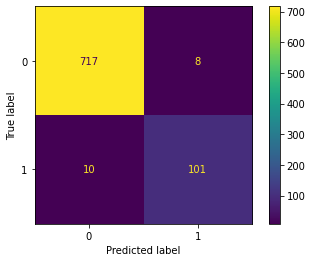

In [133]:
cm = confusion_matrix(y_test, y_pred, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model2.classes_)
disp.plot()
plt.show()

In [134]:
with mlflow.start_run():
        mlp = MLPClassifier()
        mlp.fit(X_train_features, y_train)

        predicted_qualities = mlp.predict(X_test_features)

        aucpr = eval_metrics(y_test, predicted_qualities)

        print("MLP Classifier model (Area under Precision_Recall Curve={:f}):".format(aucpr))
      
        mlflow.log_param("Area under Precision Recall Curve", aucpr)
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(mlp, "model", registered_model_name="MLPClassifierModel")
        else:
            mlflow.sklearn.log_model(mlp, "model")

MLP Classifier model (Area under Precision_Recall Curve=0.924302):


In [135]:
!zip -r /content/mlrunsMLP.zip /content/mlruns

updating: content/mlruns/ (stored 0%)
updating: content/mlruns/.trash/ (stored 0%)
updating: content/mlruns/0/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/Area under Precision Recall Curve (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/meta.yaml (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.runName (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.log-model.history (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.user (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.source.type (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/m

In [136]:
from google.colab import files
files.download("/content/mlrunsMLP.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Naive Bayes Classifier

### Gaussian NB Classifier

In [137]:
model3 = GaussianNB()
model3.fit(X_train_features.toarray() , y_train)

GaussianNB()

In [138]:
# prediction on training data

prediction_on_training_data = model3.predict(X_train_features.toarray())
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)

In [139]:
print('Accuracy on training data : ', accuracy_on_training_data)

Accuracy on training data :  0.9532958912208099


In [140]:
# prediction on test data

y_pred = model3.predict(X_test_features.toarray())
accuracy_on_test_data = accuracy_score(y_test, y_pred)

In [141]:
print('Accuracy on test data : ', accuracy_on_test_data)

Accuracy on test data :  0.9700956937799043


In [142]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       725
           1       0.91      0.86      0.88       111

    accuracy                           0.97       836
   macro avg       0.95      0.92      0.93       836
weighted avg       0.97      0.97      0.97       836



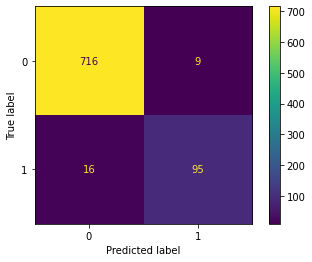

In [143]:
cm = confusion_matrix(y_test, y_pred, labels=model3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model3.classes_)
disp.plot()
plt.show()

In [144]:
with mlflow.start_run():
        nb = GaussianNB()
        nb.fit(X_train_features.toarray(), y_train)

        predicted_qualities = nb.predict(X_test_features.toarray())

        aucpr = eval_metrics(y_test, predicted_qualities)

        print("Gaussian NB model (Area under Precision_Recall Curve={:f}):".format(aucpr))
      
        mlflow.log_param("Area under Precision Recall Curve", aucpr)
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(mlp, "model", registered_model_name="GaussianNBModel")
        else:
            mlflow.sklearn.log_model(mlp, "model")

Gaussian NB model (Area under Precision_Recall Curve=0.894228):


In [145]:
!zip -r /content/mlrunsNB.zip /content/mlruns

updating: content/mlruns/ (stored 0%)
updating: content/mlruns/.trash/ (stored 0%)
updating: content/mlruns/0/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/params/Area under Precision Recall Curve (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/meta.yaml (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/ (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.runName (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.log-model.history (deflated 44%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.user (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/mlflow.source.type (stored 0%)
updating: content/mlruns/0/2d098a1d725b4bb6a2bfed68d6c6c544/tags/m

In [146]:
files.download("/content/mlrunsNB.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>